# Group 6, Project 2
### Sasha Morrison


## Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
# from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import calendar
from stats_can import StatsCan
plt.style.use('fivethirtyeight')

In [2]:
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410029301

# unemployment data
ue = pd.read_csv('data/unemployment.csv')
ue = ue.loc[ue.GEO == 'Canada']
ue['MONTH'] = pd.to_datetime(ue.REF_DATE)
ue['MONTH'] = ue['MONTH'].dt.strftime("%m")
col = ['REF_DATE', 'VALUE', 'MONTH']
ue = ue[col]
ue['pct'] = ue['VALUE'].pct_change()
ue['pct'].iat[0] = 0

ue2020 = ue.loc[ue.REF_DATE.str.contains("2020")]
ue2019 = ue.loc[ue.REF_DATE.str.contains("2019")]
ue2020 = ue2020.reset_index(drop=True)
ue2019 = ue2019.reset_index(drop=True)
ueA = ue.loc[ue.REF_DATE.str.contains("2020")|ue.REF_DATE.str.contains("2019")]
ueB = ue.loc[ue.REF_DATE.str.contains("2007")|ue.REF_DATE.str.contains("2008")|ue.REF_DATE.str.contains("2009")]
ueC = ue.loc[ue.REF_DATE.str.contains("2001")|ue.REF_DATE.str.contains("2002")|ue.REF_DATE.str.contains("2003")]
ueA = ueA.reset_index(drop=True)
ueB = ueB.reset_index(drop=True)
ueC = ueC.reset_index(drop=True)
ue.head()

,REF_DATE,VALUE,MONTH,pct
0,2001-07,7.0,07,0.000000
1,2001-08,7.2,08,0.028571
2,2001-09,7.1,09,-0.013889
3,2001-10,6.9,10,-0.028169
4,2001-11,6.8,11,-0.014493


In [3]:
sc = StatsCan()
# inflation data
inf = sc.table_to_df("18-10-0256-01")
col = ['REF_DATE', 'VALUE']
inf = inf.loc[inf['Alternative measures'] == 'Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada, seasonally adjusted']
inf = inf[col]
inf['pct'] = inf['VALUE'].pct_change()
inf['pct'].iat[0] = 0


# global financial crisis inflation (Canada)
gfc_inf = inf.loc[ (inf['REF_DATE'] > '2007') & (inf['REF_DATE'] < '2010') ]
gfc_inf = gfc_inf.reset_index(drop=True)
# covid inflation (Canada)
cvd_inf = inf.loc[ (inf['REF_DATE'] > '2018') & (inf['REF_DATE'] < '2021') ]
cvd_inf = cvd_inf.reset_index(drop=True)
gfc_inf.head()

,REF_DATE,VALUE,pct
0,2007-02-01,108.6,0.002770
1,2007-03-01,108.8,0.001842
2,2007-04-01,109.0,0.001838
3,2007-05-01,109.1,0.000917
4,2007-06-01,109.3,0.001833


In [4]:
# various gdp data
tgdp = pd.read_csv('data/tot_gdp.csv')
hgdp = pd.read_csv('data/household_gdp.csv')
cgdp = pd.read_csv('data/constant_gdp_cap.csv')
tgdp['DATE'] = pd.to_datetime(hgdp['DATE'] )
hgdp['DATE'] = pd.to_datetime(hgdp['DATE'] )
cgdp['DATE'] = pd.to_datetime(hgdp['DATE'] )
tgdp.columns = ['DATE', 'GDP']
hgdp.columns = ['DATE', 'Debt/GDP']
cgdp.columns = ['DATE', 'Const. GDP/cap']
tgdp['pct'] = hgdp['Debt/GDP'].pct_change()
hgdp['pct'] = hgdp['Debt/GDP'].pct_change()
cgdp['pct'] = cgdp['Const. GDP/cap'].pct_change()
tgdp['pct'].iat[0] = 0
hgdp['pct'].iat[0] = 0
cgdp['pct'].iat[0] = 0
tgdp.head()

,DATE,GDP,pct
0,2005-01-01,8.589275e+10,0.000000
1,2005-04-01,8.806525e+10,0.015466
2,2005-07-01,9.018700e+10,0.014435
3,2005-10-01,9.144675e+10,0.006942
4,2006-01-01,9.387025e+10,0.003040


In [5]:
#https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html

# total covid cases Canada
covid = pd.read_csv('data/covid_data.csv')
covid = covid.loc[covid.prname == 'Canada']
covid = covid.reset_index(drop=True)
covid['date'] = pd.to_datetime(covid.date)
covid['delta'] = covid.numconf.shift(periods=1)
covid['delta'] =  covid.numconf - covid.delta 
covid['delta'].iat[0] = 4 # hard code first val
covid['delta_death'] = covid['numdeaths'].diff()
covid['delta_death'].iat[0] = 0
col = [ 'date', 'numconf','numdeaths','delta', 'delta_death']
covid = covid[col]
covid.head()

,date,numconf,numdeaths,delta,delta_death
0,2020-01-31,4,0.0,4.0,0.0
1,2020-02-08,7,0.0,3.0,0.0
2,2020-02-16,8,0.0,1.0,0.0
3,2020-02-21,9,0.0,1.0,0.0
4,2020-02-24,10,0.0,1.0,0.0


# Literature

![Lit](data/pic.png)

# Covid in Canada

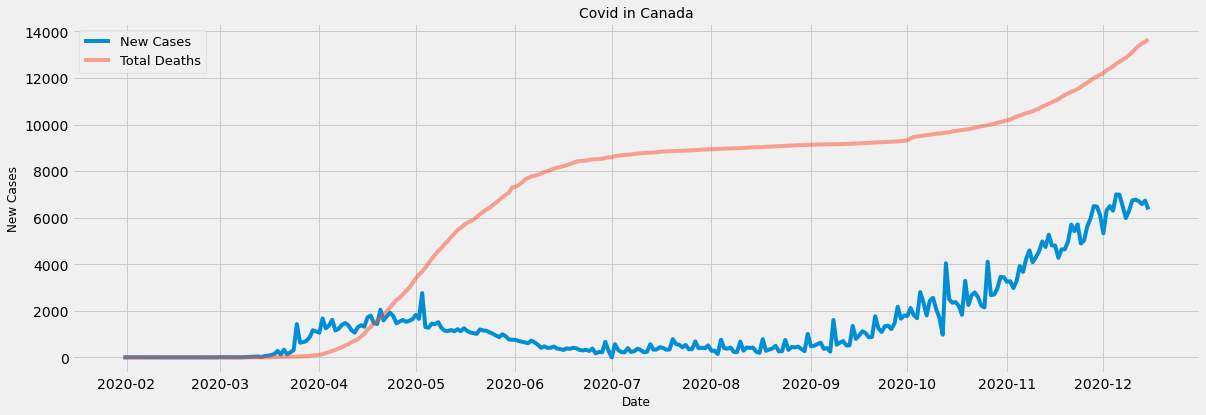

In [6]:
# daily covid change, Canada
fig, ax = plt.subplots(nrows=1, figsize = (18,6))
ax.plot(covid['date'], covid['delta'], label='New Cases')
ax.plot(covid['date'], covid['numdeaths'], label='Total Deaths', alpha=0.5)
plt.title('Covid in Canada', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('New Cases', fontsize = 12)
plt.xticks(rotation=0)
plt.legend(fontsize = 13, loc = 'upper left')
plt.show()

# Mark these:
# 11 Feb, 2020 Covid named
# 7 March, 100,000 cases global reported
# 11 March, Pandemic Dec
# 31 May, 222 covid deaths (highest daily)

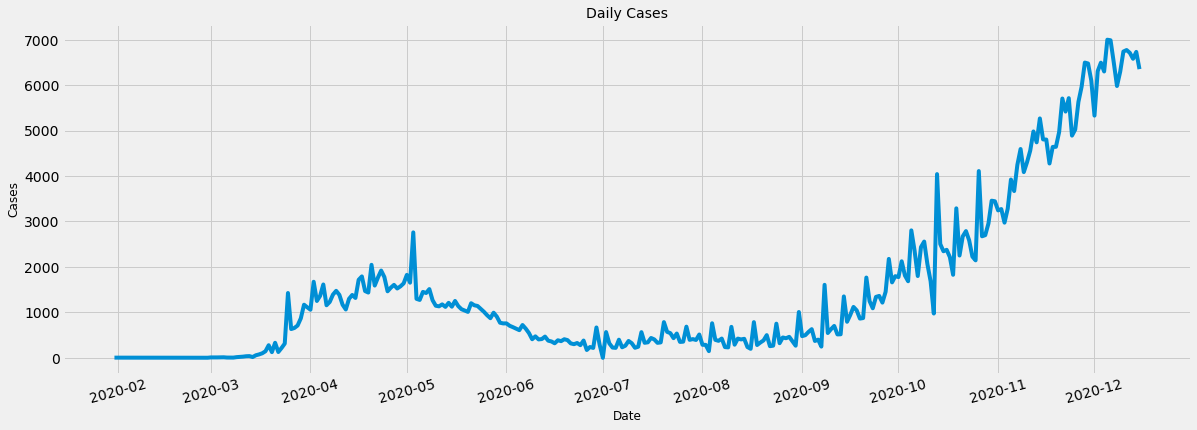

In [7]:
fig, ax = plt.subplots(nrows=1, figsize = (18,6))
ax.plot(covid['date'], covid['delta'])
plt.title('Daily Cases', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cases', fontsize = 12)
plt.xticks(rotation=15)
plt.show()

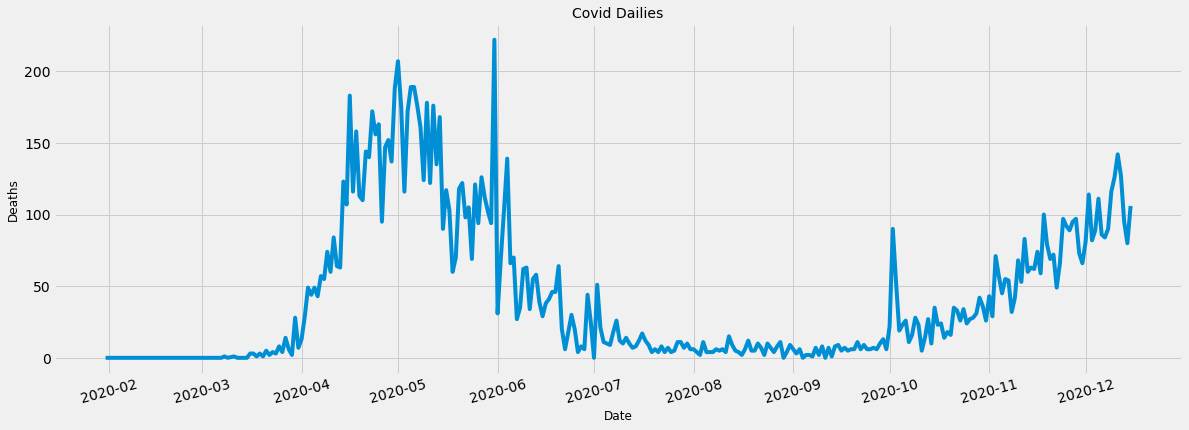

In [8]:
fig, ax = plt.subplots(nrows=1, figsize = (18,6))
ax.plot(covid['date'], covid['delta_death'], label='Change in Deaths %')
plt.title('Covid Dailies', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Deaths', fontsize = 12)
plt.xticks(rotation=15)
plt.show()

# Unemployment

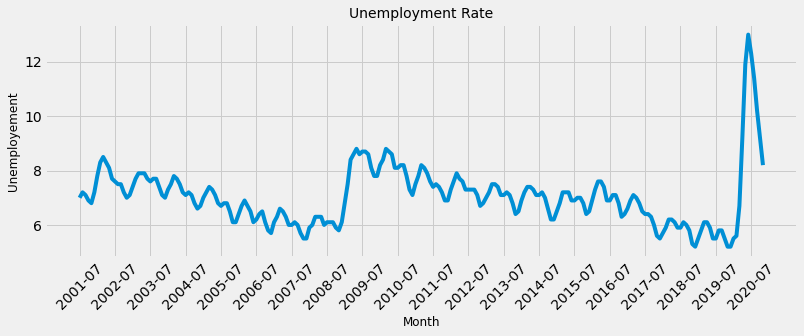

In [9]:
# Unemp in Canada over time
fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (12,4))
ax.plot(ue.REF_DATE, ue.VALUE)
plt.title('Unemployment Rate', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployement', fontsize = 12)
plt.xticks([i for i in ue.REF_DATE[::12]],rotation=45)
plt.show()

## Comparing 2019 & 2020 Unemployment

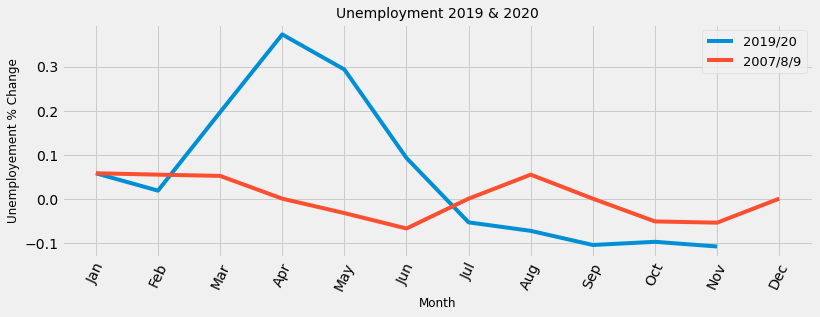

In [10]:
month = calendar.month_name[1:13]
months = []
n = 1
for i in range(n):
    months.extend(month)
mon = [ i[:3] for i in months ]

fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (12,4))
ax.plot(ue2020.index, ue2020.pct, label = '2019/20')
ax.plot(ue2019.index, ue2019.pct, label = '2007/8/9')
plt.title('Unemployment 2019 & 2020', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployement % Change', fontsize = 12)
plt.legend(fontsize = 13, loc = 'upper right')
plt.xticks(range(12),mon, rotation=65)
plt.show()

## Statistical Test  

Assuming a normal distribution:
If p < 0.05, the null hypothesis is rejected

In [11]:
stats.ttest_ind(ue2020.VALUE, ue2019.VALUE) 
# p << 0.05 so it is significant

Ttest_indResult(statistic=4.82597270109764, pvalue=9.04905188727354e-05)

# GDP & Inflation comparisons

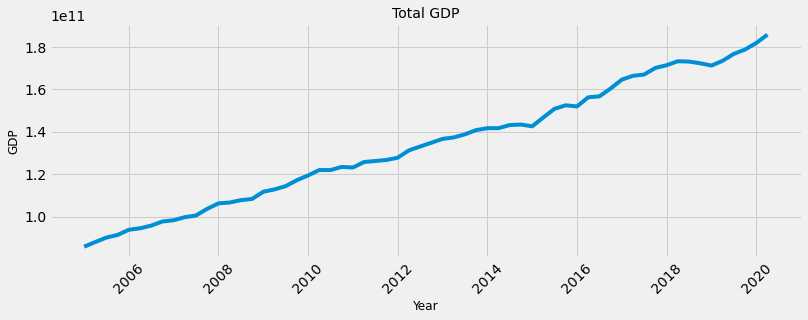

In [12]:
fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (12,4))
ax.plot(tgdp['DATE'],tgdp['GDP'], label = 'GDP')
plt.title('Total GDP', fontsize = 14)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('GDP', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

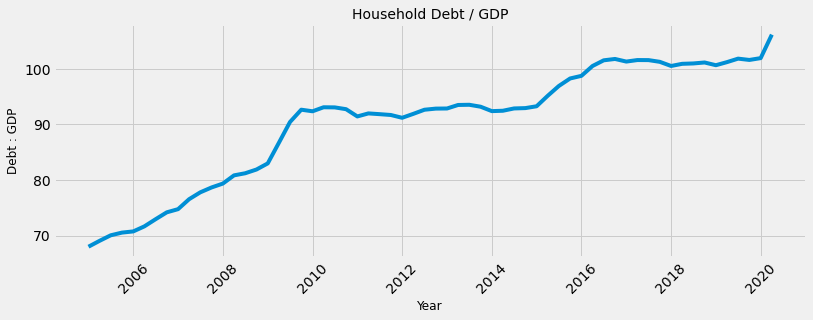

In [13]:
fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (12,4))
ax.plot(hgdp['DATE'],hgdp['Debt/GDP'], label = 'Debt/GDP')
plt.title('Household Debt / GDP', fontsize = 14)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Debt : GDP', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

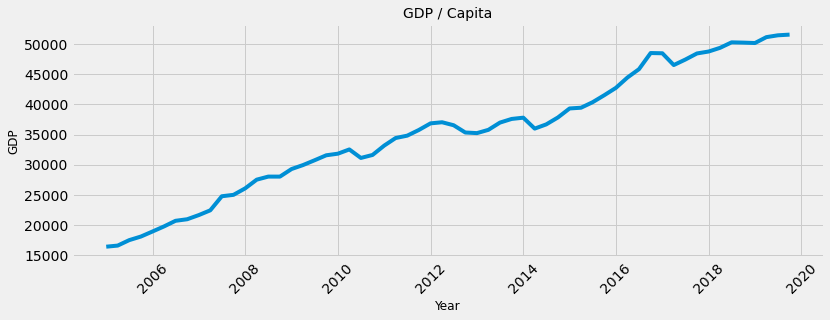

In [20]:
fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (12,4))
ax.plot(cgdp['DATE'],cgdp['Const. GDP/cap'], label = 'GDP/Cap')
plt.title('GDP / Capita', fontsize = 14)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('GDP', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

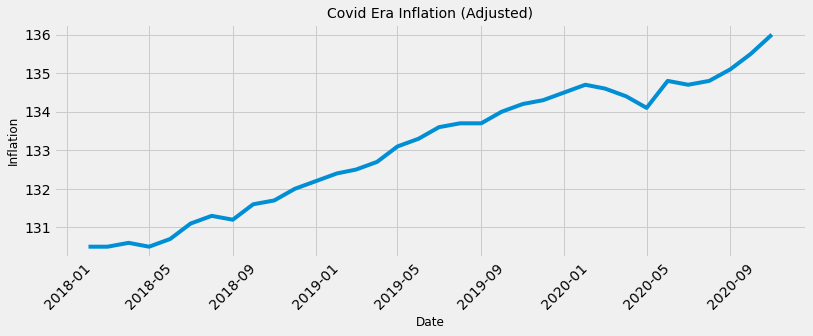

In [15]:
fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (12,4))
ax.plot(cvd_inf['REF_DATE'],cvd_inf['VALUE'])
plt.title('Covid Era Inflation (Adjusted)', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Inflation', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

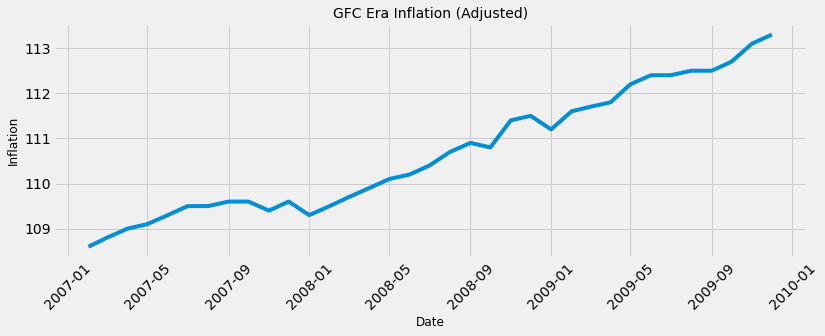

In [16]:
fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (12,4))
ax.plot(gfc_inf['REF_DATE'],gfc_inf['VALUE'])
plt.title('GFC Era Inflation (Adjusted)', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Inflation', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

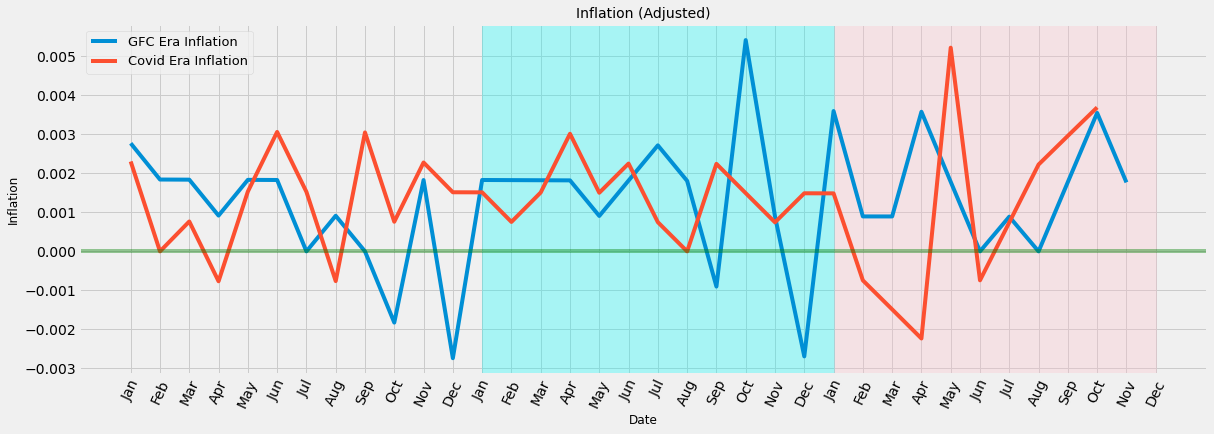

In [17]:
month = calendar.month_name[1:13]
months = []
n = 3
for i in range(n):
    months.extend(month)
mon = [ i[:3] for i in months ]

fig, ax = plt.subplots(nrows=1, sharey=False, figsize = (18,6))
ax.plot(gfc_inf.index,gfc_inf['pct'], label='GFC Era Inflation')
ax.plot(cvd_inf.index,cvd_inf['pct'], label='Covid Era Inflation')
plt.title('Inflation (Adjusted)', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Inflation', fontsize = 12)
plt.xticks(range(36),mon, rotation=65)
plt.axhline(color='g', alpha=0.4)
plt.legend(fontsize = 13, loc = 'upper left')
# 2008/2019
plt.axvspan(12, 24, color='cyan', alpha=0.3)
# 2009/2020
plt.axvspan(24, 35, color='pink', alpha=0.3)
plt.show()

# Looking Forward

In [18]:
fitted_model = ExponentialSmoothing(ue['VALUE'],
                                    trend='mul',
                                    seasonal='mul',
                                    seasonal_periods=12).fit()
forecast = fitted_model.forecast(13)
forecast = forecast.reset_index(drop=True)
ind = range(22,35)
forecast.index = ind
# produces a series of 'seasonal_periods' data points
# needs to be implemented into the forecast charts below

C:\Users\Sasha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Sasha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


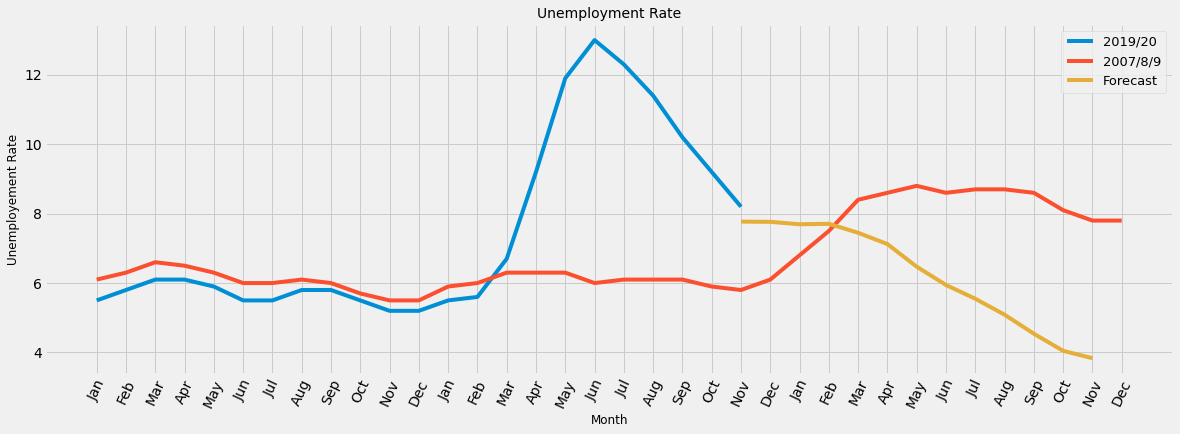

In [19]:
month = calendar.month_name[1:13]
months = []
n = 3
for i in range(n):
    months.extend(month)
mon = [ i[:3] for i in months ]


fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (18,6))
ax.plot(ueA.index, ueA.VALUE, label = '2019/20')
ax.plot(ueB.index, ueB.VALUE, label = '2007/8/9')
ax.plot(forecast.index, forecast, label = 'Forecast')
plt.title('Unemployment Rate', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployement Rate', fontsize = 12)
plt.legend(fontsize = 13, loc = 'upper right')
plt.xticks(range(36),mon, rotation=65)
plt.show()
#ueA VALUE has 23 vals, forecast should be 13
# could: match Dec 2007 to Feb 2020